# Data Format Guide

UpSetPlot fundamentally is about visualizing datapoints (or data aggregates) that are each assigned to one or more categories. Curiously, there are many ways to represent categories as data structures. Object 1 belongs to categories `A` and `B` and object 2 belongs to category `B` only, this information can be represented by:

* listing the memberships for each object, i.e.
  ```
  [["A", "B"],  # object 1
   ["B"]]       # object 2
  ```
* listing the contents of each category, i.e.
  ```
  {"A": [1], "B": [1, 2]}
  ```
* using a boolean-valued indicator matrix (perhaps columns in a larger DataFrame), i.e.
  ```
  #  A      B
  [[ True,  True ],  # object 1
   [ False, True ]]  # object 2
  ```

Moreover, UpSetPlot aims to handle both of the following cases:

* where only aggregates (e.g. counts) of the values in each category subset are given; and
* there are data points with several attributes in each category subset, where these attributes can be visualized as well as aggregates.

This guide reviews the internal data format and alternative representations, but we recommend using the helper functions [`from_memberships`](api.html#upsetplot.from_memberships), [`from_contents`](api.html#upsetplot.from_contents) or [`from_indicators`](api.html#upsetplot.from_indicators) depending on how it's most convenient to express your data.

## Internal data format

UpSetPlot internally works with data based on [Pandas](https://pandas.pydata.org/) data structres: a Series when all you care about is counts, or a DataFrame when you're interested in visualising additional properties of the data, such as with the `UpSet.add_catplot` method.

UpSetPlot expects the Series or DataFrame to have a MultiIndex as input, with this index being an indicator matrix. Specifically, each category is a level in the `pandas.MultiIndex` with boolean values.

Note: This internal data format may change in a future version since it is not efficient. Using the `from_*` methods will provide more stable compatibility with future releases.

### Use `Series` as input

Below is a minimal example using `Series` as input:  


In [1]:
from upsetplot import generate_counts

example_counts = generate_counts()
example_counts

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

This is a `pandas.Series` with 3-level Multi-index. Each level is a `Set`: `cat0`, `cat1`, and `cat2`. Each row is a unique subset with boolean values in indices indicating memberships of each row. The value in each row indicates the number of observations in each subset. `upsetplot` will simply plot these numbers when supplied with a `Series`:  


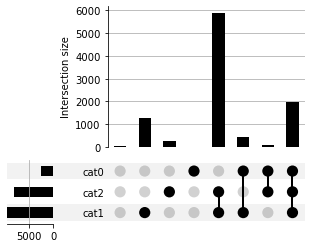

In [2]:
from upsetplot import UpSet

ax_dict = UpSet(example_counts).plot()

Alternatively, we can supply a `Series` with each observation in a row:  


In [3]:
from upsetplot import generate_samples

example_values = generate_samples().value
example_values

cat0   cat1   cat2
False  True   True    1.652317
              True    1.510447
       False  True    1.584646
              True    1.279395
       True   True    2.338243
                        ...   
              True    1.701618
              True    1.577837
True   True   True    1.757554
False  True   True    1.407799
True   True   True    1.709067
Name: value, Length: 10000, dtype: float64

In this case, we can use `subset_size='count'` to have `upsetplot` count the number of observations in each unique subset and plot them:  


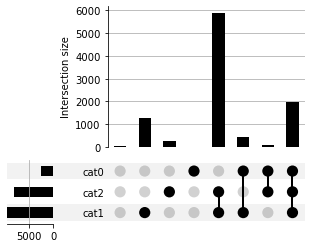

In [4]:
from upsetplot import UpSet

ax_dict = UpSet(example_values, subset_size="count").plot()

Or, we can weight each subset's size by the series value:

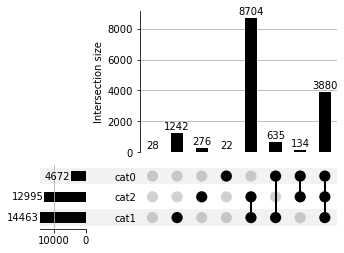

In [5]:
from upsetplot import UpSet

ax_dict = UpSet(example_values, subset_size="sum", show_counts=True).plot()

### Use `DataFrame` as input: 

A `DataFrame` can also be used as input to carry additional information.  


In [6]:
from upsetplot import generate_samples

example_samples_df = generate_samples()
example_samples_df.head()

index     value
cat0  cat1  cat2                 
False True  True      0  1.652317
            True      1  1.510447
      False True      2  1.584646
            True      3  1.279395
      True  True      4  2.338243

In this data frame, each observation has two variables: `index` and `value`. If we simply want to count the number of observations in each unique subset, we can use `subset_size='count'`:  


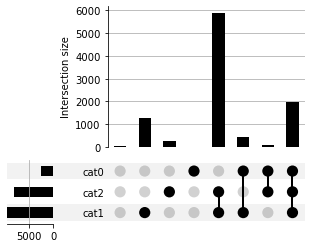

In [7]:
from upsetplot import UpSet

ax_dict = UpSet(example_samples_df, subset_size="count").plot()

If for some reason, we want to plot the sum of a variable in each subset (eg. `index`), we can use `sum_over='index'`. This will make `upsetplot` to take sum of a given variable in each unique subset and plot that number:  


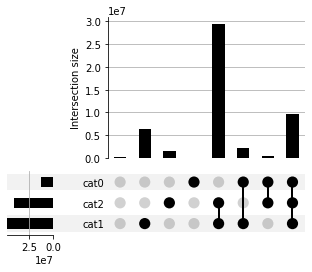

In [8]:
from upsetplot import UpSet

ax_dict = UpSet(example_samples_df, sum_over="index", subset_size="sum").plot()

## Convert Data to UpSet-compatible format

We can convert data from common formats to be compatible with `upsetplot`.

Suppose we have three categories (the data is not scientifically true!):  


In [9]:
mammals = ["Cat", "Dog", "Horse", "Sheep", "Pig", "Cattle", "Rhinoceros", "Moose"]
herbivores = ["Horse", "Sheep", "Cattle", "Moose", "Rhinoceros"]
domesticated = ["Dog", "Chicken", "Horse", "Sheep", "Pig", "Cattle", "Duck"]
(mammals, herbivores, domesticated)

(['Cat', 'Dog', 'Horse', 'Sheep', 'Pig', 'Cattle', 'Rhinoceros', 'Moose'],
 ['Horse', 'Sheep', 'Cattle', 'Moose', 'Rhinoceros'],
 ['Dog', 'Chicken', 'Horse', 'Sheep', 'Pig', 'Cattle', 'Duck'])

Since this format lists the entries in each category, we can use `from_contents` to construct a data frame ready for plotting.

`from_contents` takes a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) as input. The input dictionary should have categories names as key and a [list](https://docs.python.org/3/tutorial/datastructures.html) or set of category members as values:  



In [10]:
from upsetplot import from_contents

animals = from_contents(
    {"mammal": mammals, "herbivore": herbivores, "domesticated": domesticated}
)
animals

id
mammal herbivore domesticated            
True   False     False                Cat
                 True                 Dog
       True      True               Horse
                 True               Sheep
       False     True                 Pig
       True      True              Cattle
                 False         Rhinoceros
                 False              Moose
False  False     True             Chicken
                 True                Duck

Now we can plot:  


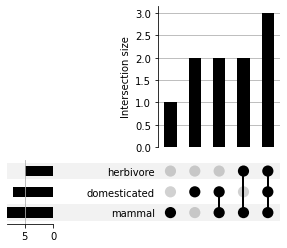

In [11]:
from upsetplot import UpSet

ax_dict = UpSet(animals, subset_size="count").plot()

Alternatively, our input data may have been structured by species, allowing us to use `from_memberships`:

In [12]:
from upsetplot import from_memberships

animal_memberships = {
    "Cat": "Mammal",
    "Dog": "Mammal,Domesticated",
    "Horse": "Mammal,Herbivore,Domesticated",
    "Sheep": "Mammal,Herbivore,Domesticated",
    "Pig": "Mammal,Domesticated",
    "Cattle": "Mammal,Herbivore,Domesticated",
    "Rhinoceros": "Mammal,Herbivore",
    "Moose": "Mammal,Herbivore",
    "Chicken": "Domesticated",
    "Duck": "Domesticated",
}

# Turn this into a list of lists:
animal_membership_lists = [
    categories.split(",") for categories in animal_memberships.values()
]

animals = from_memberships(animal_membership_lists)
animals

Domesticated  Herbivore  Mammal
False         False      True      1
True          False      True      1
              True       True      1
                         True      1
              False      True      1
              True       True      1
False         True       True      1
                         True      1
True          False      False     1
                         False     1
Name: ones, dtype: int64

This should produce the same plot:

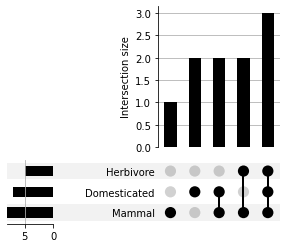

In [13]:
from upsetplot import UpSet

ax_dict = UpSet(animals, subset_size="count").plot()

## When category membership is indicated in DataFrame columns

Let's take a look at a `movies` dataset like that used in the [original publication by Alexander Lex et al.](https://caleydo.org/publications/2014_infovis_upset/).


In [14]:
import pandas as pd

movies = pd.read_csv(
    "https://raw.githubusercontent.com/peetck/IMDB-Top1000-Movies/master/IMDB-Movie-Data.csv"
)
movies.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40


Here Genre category membership is represented with a comma-separated Genre column.

`from_memberships` is our best option:

In [15]:
movies_by_genre = from_memberships(movies.Genre.str.split(","), data=movies)
movies_by_genre

Rank  \
Action Adventure Animation Biography Comedy Crime Drama Family Fantasy History Horror Music Musical Mystery Romance Sci-Fi Sport Thriller War   Western         
True   True      False     False     False  False False False  False   False   False  False False   False   False   True   False False    False False       1   
False  True      False     False     False  False False False  False   False   False  False False   True    False   True   False False    False False       2   
       False     False     False     False  False False False  False   False   True   False False   False   False   False  False True     False False       3   
                 True      False     True   False False True   False   False   False  False False   False   False   False  False False    False False       4   
True   True      False     False     False  False False False  True    False   False  False False   False   False   False  False False    False False       5   
...                                                                                                                                                       ...   
False  False     False     False     False  True  True  False  False   False   False  False False   True    False   False  False False    False False     996   
                                            False False False  False   False   True   False False   False   False   False  False False    False False     997   
                                                  True  False  False   False   False  True  False   False   True    False  False False    False False     998   
       True      False     False     True   False False False  False   False   False  False False   False   False   False  False False    False False     999   
       False     False     False     True   False False True   True    False   False  False False   False   False   False  False False    False False    1000   

                                                                                                                                                                           Title  \
Action Adventure Animation Biography Comedy Crime Drama Family Fantasy History Horror Music Musical Mystery Romance Sci-Fi Sport Thriller War   Western                            
True   True      False     False     False  False False False  False   False   False  False False   False   False   True   False False    False False    Guardians of the Galaxy   
False  True      False     False     False  False False False  False   False   False  False False   True    False   True   False False    False False                 Prometheus   
       False     False     False     False  False False False  False   False   True   False False   False   False   False  False True     False False                      Split   
                 True      False     True   False False True   False   False   False  False False   False   False   False  False False    False False                       Sing   
True   True      False     False     False  False False False  True    False   False  False False   False   False   False  False False    False False              Suicide Squad   
...                                                                                                                                                                          ...   
False  False     False     False     False  True  True  False  False   False   False  False False   True    False   False  False False    False False       Secret in Their Eyes   
                                            False False False  False   False   True   False False   False   False   False  False False    False False            Hostel: Part II   
                                                  True  False  False   False   False  True  False   False   True    False  False False    False False     Step Up 2: The Streets   
       True      False     False     True   False False False  False   False   

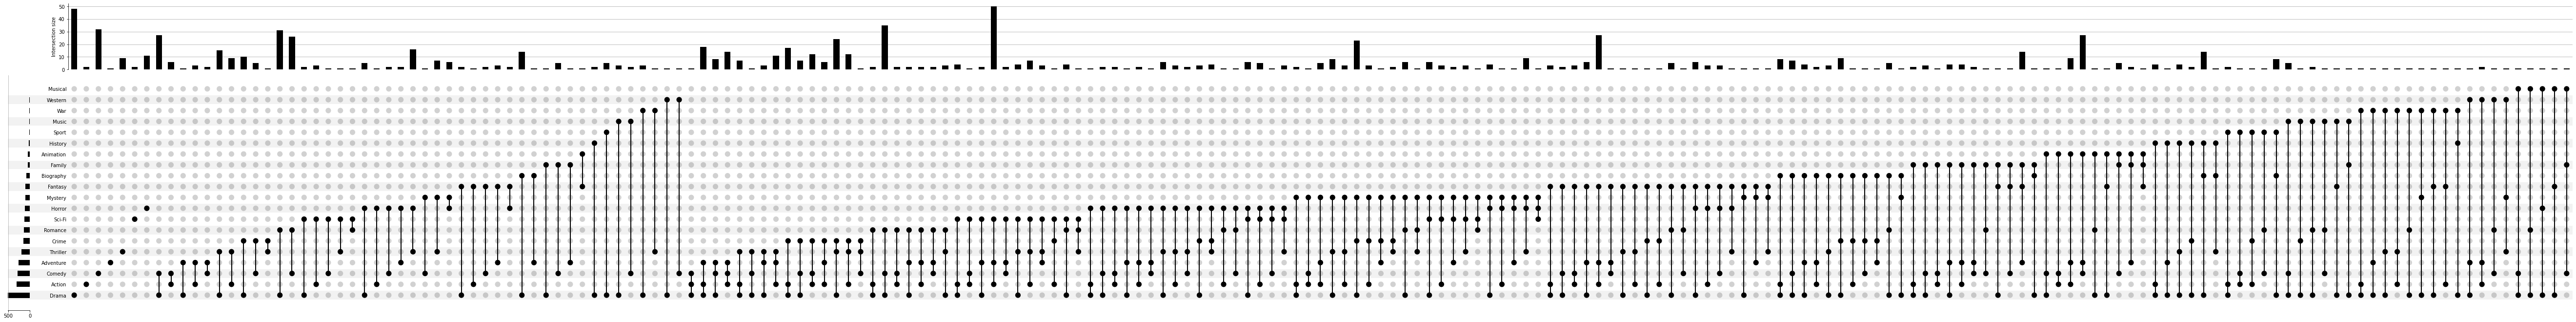

In [16]:
UpSet(movies_by_genre)

Given the size of this plot, we limit ourselves to frequent genres:

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7faaa87e8ef0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7faad876a7b8>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7faac8b93978>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7faaf845f978>}

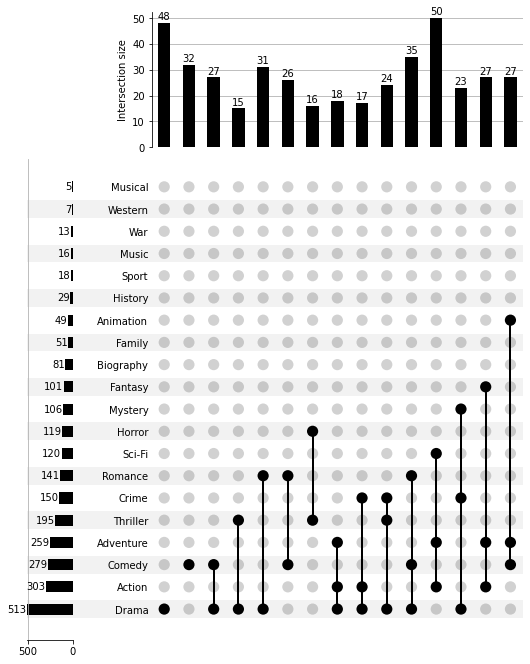

In [17]:
UpSet(movies_by_genre, min_subset_size=15, show_counts=True).plot()

If the genres were instead presented as a series of boolean columns, we could use `from_indicators`.

In [18]:
genre_indicators = pd.DataFrame(
    [{cat: True for cat in cats} for cats in movies.Genre.str.split(",").values]
).fillna(False)
genre_indicators

,Action,Adventure,Sci-Fi,Mystery,Horror,Thriller,Animation,Comedy,Family,Fantasy,Drama,Music,Biography,Romance,History,Crime,Western,War,Musical,Sport
0,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
996,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
997,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False
998,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
from upsetplot import from_indicators

# this produces the same result as from_memberships above
movies_by_genre = from_indicators(genre_indicators, data=movies)

These columns could also be part of the original matrix. For this case `from_indicators` allows the `indicators` to be specified as a list of column names, or as a function of the data frame.

In [20]:
movies_with_indicators = pd.concat([movies, genre_indicators], axis=1)
movies_with_indicators

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,...,Drama,Music,Biography,Romance,History,Crime,Western,War,Musical,Sport
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,...,False,False,False,False,False,False,False,False,False,False
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,...,False,False,False,False,False,False,False,False,False,False
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,...,False,False,False,False,False,False,False,False,False,False
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,...,False,False,False,False,False,False,False,False,False,False
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Secret in Their Eyes,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo...",Billy Ray,"Chiwetel Ejiofor, Nicole Kidman, Julia Roberts...",2015,111,6.2,27585,...,True,False,False,False,False,True,False,False,False,False
996,997,Hostel: Part II,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,...,False,False,False,False,False,False,False,False,False,False
997,998,Step Up 2: The Streets,"Drama,Music,Romance",Romantic sparks occur between two dance studen...,Jon M. Chu,"Robert Hoffman, Briana Evigan, Cassie Ventura,...",2008,98,6.2,70699,...,True,True,False,True,False,False,False,False,False,False
998,999,Search Party,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,...,False,False,False,False,False,False,False,False,False,False


We can now specify some or all category column names instead of passing a separate indicator matrix:

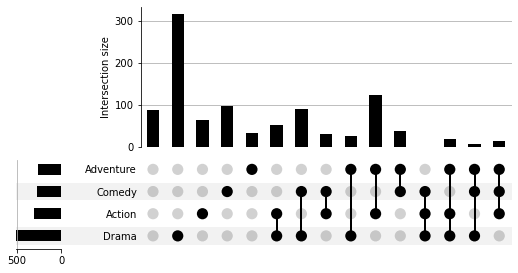

In [21]:
UpSet(
    from_indicators(
        ["Drama", "Action", "Comedy", "Adventure"], data=movies_with_indicators
    )
)

Or we can use `pd.select_dtypes` to extract out all boolean columns:

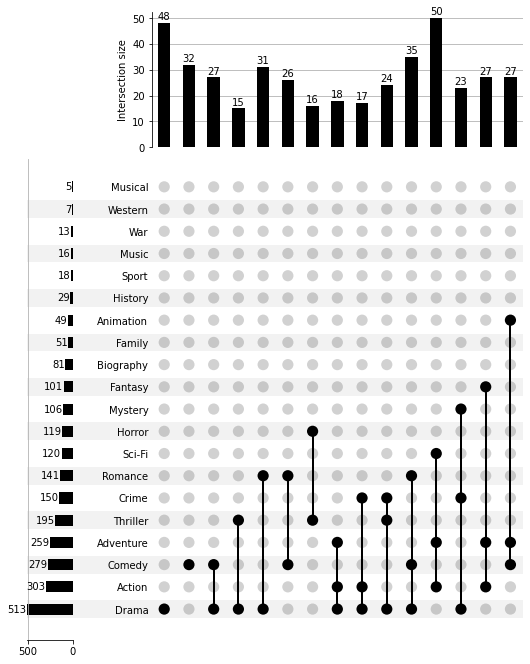

In [22]:
UpSet(
    from_indicators(lambda df: df.select_dtypes(bool), data=movies_with_indicators),
    min_subset_size=15,
    show_counts=True,
)